Gabriele LEBLANC--SPANU

In [2]:
import numpy as np
import math
import random
import string
import matplotlib.pyplot as plt
import collections

In [3]:
class PersonGenerator:
    def __init__(self, namefile, surnamefile):
        with open(namefile, encoding='utf-8') as f:
            self.names = f.read().split()
        with open(surnamefile, encoding='utf-8') as f:
            self.surnames = f.read().split()

    def getDNI(self):
        number = random.randint(1000000,10000000)
        letter = random.choice(string.ascii_letters.upper())
        return str(number)+letter

    def getName(self):
        name = random.choice(self.names)
        surname1 = random.choice(self.surnames)
        surname2 = random.choice(self.surnames)
        return ' '.join((name,surname1,surname2))

    def get(self):
        return self.getName()+' '+self.getDNI()

# an instance of person generator
people = PersonGenerator('nombres.txt','apellidos.txt')

In [4]:
class CuckooFilter:
    def __init__(self, nmax, block_size=4, r=16, MaxNumKicks=100):
        self.MaxNumKicks = MaxNumKicks
        
        # number of fingerprints per bucket
        self.b = block_size
        # an estimation of the maximum load factor:
        # (assume the block_size is one of these keys)
        self.MaxLoadFactor = {1:0.5, 2:0.84, 4:0.95, 8:0.98}[block_size]
        
        # number of elements in the filter
        self.size = 0
        
        def nextPowerOfTwo(n): # auxiliary function to compute m from nmax and b
            k = 1
            while k < n:
                k = k << 1
            return k
        
        # estimation of m
        estimation = math.ceil(nmax/(self.MaxLoadFactor * block_size))
        self.m = nextPowerOfTwo(int(estimation))
        
        # since m is a power of 2, we can use this trick:
        # x % self.m is the same as x & self.mm1
        self.mm1 = self.m - 1
        
        # fingerprint size must be <=16 in order to use np.uint16
        assert(r <= 16)
        self.r = r
        self.maskf = (2**r)-1
        
        # the table is a numpy array, the fingerprint size is r=16 bits
        self.table = np.zeros((self.m,block_size), dtype=np.uint16)
        
        # keys are min(i1,i2) with i1,i2 alternative indices of a fingerprint
        # values are lists of fingerprints
        self.stash = dict()
    
    def __len__(self):
        # number of inserted elements
        # self.size must be incremented in add method
        # and decrementd in delete method
        return self.size
    
    def load_factor(self):
        return self.size/(self.m * self.b)

    def hashes(self, key):
        """
        returns a tuple (index, fingerprint)
        """
        h = hash(key)
        index = (h >> 16) & self.mm1
        fingerprint = h & self.maskf
        if fingerprint == 0:
            # 0 is reserved for empty slots
            fingerprint = 1
        return (index, fingerprint)
        
    def get_alternative_index(self, index, fingerprint):
        """
        obtain the alternate index position
        ^ is the bitwise exclusive-or operator
        we make a little trick to assure that the
        alternative index is different
        """
        mask = hash(fingerprint)
        while (mask & self.mm1) == 0:
            mask = hash((mask,fingerprint))
        mask = mask & self.mm1
        return index ^ mask
        
    def __contains__(self, key):
        """
        this method allows us to write "x in c"
        where c is a CuckooFilter
        """
        i1, f = self.hashes(key)
        i2    = self.get_alternative_index(i1,f)
        return (f in self.table[i1]) or (f in self.table[i2])
    
    def delete(self, key):
        """
        this method deletes an element from the
        cuckoo filter
        """
        i1, f = self.hashes(key)
        i2    = self.get_alternative_index(i1,f)
        if f in self.table[i1]:
            i, c = i1, random.choice(np.where(self.table[i1] == f)[0])
            self.table[i][c] = 0
            self.size -= 1
        elif f in self.table[i2]:
            i, c = i2, random.choice(np.where(self.table[i2] == f)[0])
            self.table[i][c] = 0
            self.size -= 1
        
    def _insert_in_cell(self, index, f):
        """
        This is an auxiliary method!
        
        - insert fingerprint f in an empty slot of self.table[index]
          and return 0
        - if the bucket if full, we should choose a random slot, swap
          the value and return the value that has been displaced from its
          position
        """
        if 0 in self.table[index]:
            self.table[index][random.choice(np.where(self.table[index] == 0)[0])] = f
            return 0
        else:
            rand_index = random.randint(0, self.b-1)
            res = self.table[index][rand_index]
            self.table[index][rand_index] = f
            return res
        
    def add(self, key):
        """
        insert the fingerprint associated to key
        in the cuckoo filter
        """
        self.size += 1
        i1, f = self.hashes(key)
        i2    = self.get_alternative_index(i1,f)
        if 0 in self.table[i1]:
            i = i1
        elif 0 in self.table[i2]:
            i = i2
        else:
            # randomly pick i1 or i2
            i = random.choice((i1,i2))
            
        probes = 0
        while f != 0 and probes < self.MaxNumKicks:
            f = self._insert_in_cell(i, f)
            if f!=0:
                i = self.get_alternative_index(i, f)
            probes += 1

        # fingerprint could be stored or we have reached max number of probes
        if f != 0:
            # at this point we could use the "stash"
            self.size -= 1
            raise KeyError("Unable to insert: " + repr(key))

In [5]:
class CuckooFilterStash(CuckooFilter):
    # add here the methods that change with the inclusion of the stash
    # note that self.stash has already been included in __init__

    # override add method
    def add(self, key):
        """
        insert the fingerprint associated to key
        in the cuckoo filter with stash
        """
        self.size += 1
        i1, f = self.hashes(key)
        i2    = self.get_alternative_index(i1,f)
        if 0 in self.table[i1]:
            i = i1
        elif 0 in self.table[i2]:
            i = i2
        else:
            # randomly pick i1 or i2
            i = random.choice((i1,i2))
            
        probes = 0
        while f != 0 and probes < self.MaxNumKicks:
            f = self._insert_in_cell(i, f)
            if f!=0:
                i = self.get_alternative_index(i, f)
            probes += 1

        # fingerprint could be stored or we have reached max number of probes
        if f != 0:
            # at this point we use the "stash"
            if self.load_factor() < self.MaxLoadFactor:
                if min(i1, i2) in self.stash.keys():
                    self.stash[min(i1, i2)].append(f)
                else:
                    self.stash[min(i1, i2)] = [f]
            else:
                self.size -= 1
                raise KeyError("Unable to insert: " + repr(key))

    
    # override delete method
    def delete(self, key):
        """
        this method deletes an element from the
        cuckoo filter with stash
        """
        i1, f = self.hashes(key)
        i2    = self.get_alternative_index(i1,f)
        if min(i1, i2) in self.stash:
            self.size -= 1
            self.stash[min(i1, i2)].pop()
            if len(self.stash[min(i1, i2)])==0:
                self.stash.pop(min(i1, i2))
        else:
            super().delete(key)
    
    # override __contains__ method
    def __contains__(self, key):
        """
        this method allows us to write "x in c"
        where c is a CuckooFilter with stash
        """
        i1, f = self.hashes(key)
        i2    = self.get_alternative_index(i1,f)
        if min(i1, i2) in self.stash:
            return f in self.stash[min(i1, i2)]
        return (f in self.table[i1]) or (f in self.table[i2])

In [34]:
class VacuumFilter:
    def __init__(self, nmax, block_size=4, r=16, MaxNumKicks=100):
        self.MaxNumKicks = MaxNumKicks
        
        # number of fingerprints per bucket
        self.b = block_size
        # an estimation of the maximum load factor:
        # (assume the block_size is one of these keys)
        self.MaxLoadFactor = {1:0.5, 2:0.84, 4:0.95, 8:0.98}[block_size]
        
        # number of elements in the filter
        self.size = 0
        
        # we estimate L
        self.L = 1
        test = self.load_factor_test(nmax)
        while test:
            self.L *= 2
            test = self.load_factor_test(nmax)

        # calculation of  m
        self.m = math.ceil(nmax/(self.b * self.MaxLoadFactor * self.L)) * self.L
        self.mm1 = self.m - 1
        self.Lm1 = self.L - 1

        self.chunks = self.m/self.L
        
        # fingerprint size must be <=16 in order to use np.uint16
        assert(r <= 16)
        self.r = r
        self.maskf = (2**r)-1
        
        # the table is a numpy array, the fingerprint size is r=16 bits
        self.table = np.zeros((self.m,block_size), dtype=np.uint16)

        # keys are min(i1,i2) with i1,i2 alternative indices of a fingerprint
        # values are lists of fingerprints
        self.stash = dict()

    def load_factor_test(self, nmax):
        m = math.ceil(nmax/(self.b * self.MaxLoadFactor * self.L)) * self.L
        c = m/self.L
        D = nmax/c +3/2 * math.sqrt(2*nmax/c * math.log(c))
        if D < 0.97*self.b*self.L:
            return False
        return True

    
    def __len__(self):
        # number of inserted elements
        # self.size must be incremented in add method
        # and decrementd in delete method
        return self.size
    
    def load_factor(self):
        return self.size/(self.m * self.b)

    def hashes(self, key):
        """
        returns a tuple (index, fingerprint)
        """
        h = hash(key)
        index = (h >> 16) & self.mm1
        fingerprint = h & self.maskf
        if fingerprint == 0:
            # 0 is reserved for empty slots
            fingerprint = 1
        return (index, fingerprint)
        
    def get_alternative_index(self, index, fingerprint):
        """
        obtain the alternate index position
        ^ is the bitwise exclusive-or operator
        we make a little trick to assure that the
        alternative index is different
        """
        mask = hash(fingerprint)
        while (mask & self.Lm1) == 0:
            mask = hash((mask, fingerprint))
        mask = mask & self.Lm1
        return index ^ mask
        
    def __contains__(self, key):
        """
        this method allows us to write "x in c"
        where c is a CuckooFilter
        """
        i1, f = self.hashes(key)
        i2    = self.get_alternative_index(i1,f)
        if min(i1, i2) in self.stash:
            return f in self.stash[min(i1, i2)]
        return (f in self.table[i1]) or (f in self.table[i2])
    
    def delete(self, key):
        """
        this method deletes an element from the
        cuckoo filter
        """
        i1, f = self.hashes(key)
        i2    = self.get_alternative_index(i1,f)
        if min(i1, i2) in self.stash:
            self.size -= 1
            self.stash[min(i1, i2)].pop()
            if len(self.stash[min(i1, i2)])==0:
                self.stash.pop(min(i1, i2))
        else:
            if f in self.table[i1]:
                i, c = i1, random.choice(np.where(self.table[i1] == f)[0])
                self.table[i][c] = 0
                self.size -= 1
            elif f in self.table[i2]:
                i, c = i2, random.choice(np.where(self.table[i2] == f)[0])
                self.table[i][c] = 0
                self.size -= 1
        
    def _insert_in_cell(self, index, f):
        """
        This is an auxiliary method!
        
        - insert fingerprint f in an empty slot of self.table[index]
          and return 0
        - if the bucket if full, we should choose a random slot, swap
          the value and return the value that has been displaced from its
          position
        """
        if 0 in self.table[index]:
            self.table[index][random.choice(np.where(self.table[index] == 0)[0])] = f
            return 0
        else:
            for i in range(0, self.b-1):
                if 0 in self.table[self.get_alternative_index(index, self.table[index][i])]:
                    res = self.table[index][i]
                    self.table[index][i] = f
                    return res
            rand_index = random.randint(0, self.b-1)
            res = self.table[index][rand_index]
            self.table[index][rand_index] = f
            return res
        
    def add(self, key):
        """
        insert the fingerprint associated to key
        in the cuckoo filter
        """
        self.size += 1
        i1, f = self.hashes(key)
        i2    = self.get_alternative_index(i1,f)
        if 0 in self.table[i1]:
            i = i1
        elif 0 in self.table[i2]:
            i = i2
        else:
            # randomly pick i1 or i2
            i = random.choice((i1,i2))
            
        probes = 0
        while f != 0 and probes < self.MaxNumKicks:
            f = self._insert_in_cell(i, f)
            if f!=0:
                i = self.get_alternative_index(i, f)
            probes += 1

        # fingerprint could be stored or we have reached max number of probes
        if f != 0:
            # at this point we use the "stash"
            if self.load_factor() < self.MaxLoadFactor:
                if min(i1, i2) in self.stash.keys():
                    self.stash[min(i1, i2)].append(f)
                else:
                    self.stash[min(i1, i2)] = [f]
            else:
                self.size -= 1
                raise KeyError("Unable to insert: " + repr(key))

In [35]:
# simple test example
vf = VacuumFilter(nmax=10)
for word in "this is a test".split():
    vf.add(word)
for word in "another test is not this a".split():
    print(f'{word:10} -> ',word in vf)

print(vf.table) # values will change for each python session due to hash function
print(vf.size)

for word in "this is a".split():
    vf.delete(word)
for word in "another test is not this a".split():
    print(f'{word:10} -> ',word in vf)

print(vf.table)
print(vf.size)

another    ->  False
test       ->  True
is         ->  True
not        ->  False
this       ->  True
a          ->  True
[[    0     0     0     0]
 [    0 40830     0     0]
 [17082     0     0     0]
 [54266     0 30580     0]]
4
another    ->  False
test       ->  True
is         ->  False
not        ->  False
this       ->  False
a          ->  False
[[    0     0     0     0]
 [    0     0     0     0]
 [    0     0     0     0]
 [54266     0     0     0]]
1


In [36]:
vf = CuckooFilter(nmax=10)
for word in "this is a test".split():
    vf.add(word)
for _ in range(5):
    vf.add("test")
print(vf.size)
print(vf.table)
print("Last insertion failing without stash")
vf.add("test")
print("Last insertion succesful")

9
[[    0     0     0     0]
 [54266 40830 54266 54266]
 [    0     0 17082     0]
 [54266 54266 54266 30580]]
Last insertion failing without stash


KeyError: "Unable to insert: 'test'"

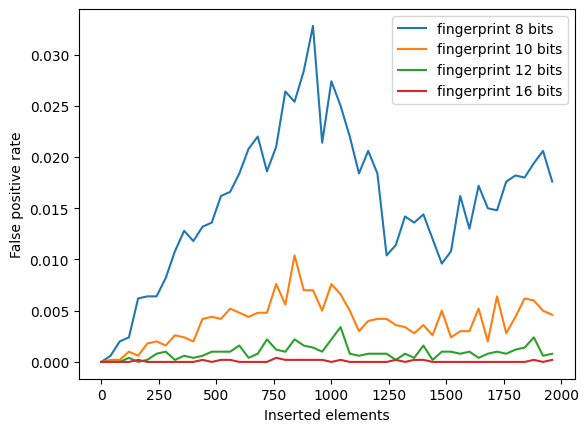

In [37]:
nmax = 2000
fingerprints = [8, 10, 12, 16]
points = 50
N = 5000

n_values = int(nmax/points)
x = np.arange(0, nmax, n_values)
y = [np.zeros(points) for i in range(len(fingerprints))]

fig, ax = plt.subplots()

for i in range(len(fingerprints)):
    fingerprint = fingerprints[i]
    
    filter = VacuumFilter(nmax=nmax, r=fingerprint)
    people = PersonGenerator('nombres.txt','apellidos.txt')

    for j in range(int(nmax)):
        person = people.get()
        filter.add(person)

        if j%n_values==0:
           y[i][j//n_values] = sum(filter.__contains__(people.get()) for k in range(N))/N

    ax.plot(x,y[i])

ax.set_ylabel("False positive rate")
ax.set_xlabel("Inserted elements")
ax.legend(["fingerprint 8 bits", "fingerprint 10 bits", "fingerprint 12 bits", "fingerprint 16 bits"])
None